## 1. Main functions and classes

First you need to download all the required libraries for this project, as well as prepare the functions and classes that will be needed for further development.

In [1]:
import pandas as pd # Importing a library to work with files
import numpy as np #Importing package for scientific computing
import nltk #Importing library for working with natural language
nltk.download('stopwords') #Download stop words 
import re #Importing library for working with regex
from sklearn.feature_extraction.text import TfidfVectorizer # Importing Tfidf Vectorizer
from sklearn.model_selection import train_test_split # importing function for splitting data

# Importing all metrics for Evaluation
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Importing some classic ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

# Importing some ensemble ML algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier

from pymystem3 import Mystem # Importing a library for lemmetization in Russian

# Importing a libraries for drawing graphs, etc.
import seaborn as sns 
import matplotlib.pyplot as plt

# Importing a library to quickly count the same words in all texts
from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maksimgrinberg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Below is a class that is responsible for almost all the functions required for data preprocessing and analysis. To create it, the class needs to pass the path leading to the CSV data file. 

In [2]:
#  A class for preprocessing data and displaying features and drawing graphs.
# object : str - path to csv file
class Preprocessing(object):

    # Instance attribute
    def __init__(self, df_name):
        self.data_name = str(df_name)
        # Creating a Pandas Dataframe and dropping a column with row indices
        self.df = pd.read_csv(df_name).drop('index', 1)
        # Preload stop words
        self.stopwords = set(nltk.corpus.stopwords.words('russian'))
        # Pre-load Mystem to speed up its work in the future
        self.mystem = Mystem()

# -----------------------------------
# Functions for data analysis
# -----------------------------------

    # display a graph of the distribution of fake and real news in dataset
    def data_distribution(self):
        x_label = "Distribution of fake and real news in " + self.data_name
        y_label = "Number of news"
        
        # draw a graph with data display
        to_plot = sns.countplot(self.df.news_class)
        to_plot.set_xlabel(x_label)
        to_plot.set_ylabel(y_label)
        
        plt.show()
    
# -----------------------------------
# Data Preconditioning Function
# -----------------------------------
    
    # This function is responsible for pre-processing the data
    # which was received when creating the class.
    # --------------
    # Parameters:
    # lowercasing: bool - convert all words to lower case
    # space_del: bool - removes all extra spaces
    # urls_del: bool - removes all urls
    # punctuation_del: bool - removes all punctuation
    # stopwords_del: bool - removes stopwords for the Russian language
    # most_freq_words_del: array [bool, int] - removes N most frequent words in texts of dataset 
    # stemming: bool - stemming words
    # lemmatization: bool - ligmatizing words
    # tfidf_vect: bool - translates news into TF-IDF vector
    # -------------
    # Return:
    # - If tfidf_vect = True returns 2 arrays of news texts and labels
    # - In all other cases returns a Pandas DataFrame
    def data_preprocess(self,
                       lowercasing = False,
                       space_del = False,
                       urls_del = False,
                       punctuation_del = False,
                       stopwords_del = False,
                       most_freq_words_del = [False, 10],
                       stemming = False,
                       lemmatization = False,
                       tfidf_vect = False):
    
    
        # Find and remove duplicates if they exist
        if self.df.duplicated().sum() != 0:
            self.df.drop_duplicates(inplace = True,
                                     ignore_index = True)
        
        # lowercasing news classes and converting them to binary
        self.df['news_class'] = self.df['news_class'].str.lower() 
        self.df.loc[(self.df.news_class == 'fake'), 'news_class'] = 0
        self.df.loc[(self.df.news_class == 'real'), 'news_class'] = 1
        
        # Lowercase all words in all news
        if lowercasing == True:
            self.df['news_text'] = self.df['news_text'].str.lower()
        
        # remove extra spaces
        if space_del == True:
            self.df['news_text'] = self.df['news_text'].apply(self.__space_rem)
        
        # remove all URLs
        if urls_del == True:
            self.df['news_text'] = self.df['news_text'].apply(self.__links_rem)
        
        # remove all punctuation
        if punctuation_del == True:
            self.df['news_text'] = self.df['news_text'].apply(self.__punct_rem)
        
        # Deciding what to use lemmatization or stemming and converting words to root form
        if lemmatization == True:
            # perform the text lemmatization process
            self.df['news_text'] = self.df['news_text'].apply(self.__lemmatize_and_tokenize)
            # tokenize lemmetized text
            self.df['news_text'] = self.df['news_text'].apply(self.__simple_tokenizer)
         
        # Tokenize the text if lemmitization was not selected and
        # you need to execute stopwords_del or most_freq_words_del or tfidf_vect
        elif stopwords_del == True or most_freq_words_del[0] == True or tfidf_vect == True:
            # Converting text to tokens
            self.df['news_text'] = self.df['news_text'].apply(self.__simple_tokenizer)
            
            # perform stemming
            if stemming == True:
                self.df['news_text'] = self.df['news_text'].apply(self.__news_stemming)
        
        # Removing stopwords for the Russian language
        if stopwords_del == True:
            self.df['news_text'] = self.df['news_text'].apply(self.__stops_rem,
                                                              args = [self.stopwords])
        # removes N most frequent words in texts of dataset
        if most_freq_words_del[0] == True:
            # looking for N most frequent words
            stops = self.__n_freq_words(self.df['news_text'].values,
                                       most_freq_words_del[1])
            # remove words from texts from our stopwords array 
            self.df['news_text'] = self.df['news_text'].apply(self.__stops_rem,
                                                              args = [stops])
        # Convert text to TF-IDF vector  
        if tfidf_vect == True:
            # Initiating and configuring TfidfVectorizer
            tf_idf = TfidfVectorizer(strip_accents=None,
                                     lowercase=False,
                                     preprocessor=None,
                                     tokenizer=self.__helper_tokenizer,
                                     use_idf=True,
                                     norm='l2',
                                     smooth_idf=True,
                                     max_features=500)
            
            # Converting each text to TF-IDF vector
            X = tf_idf.fit_transform(self.df['news_text'])
            
            # Convert labels to numbers and save them
            self.df.news_class = pd.to_numeric(self.df.news_class, errors='coerce')
            y = self.df["news_class"]
            
            return X, y
        else:
            return self.df   
         

# -----------------------------------
# Helper Functions for Data Processing
# -----------------------------------
    
    # helper function for removing extra spaces
    def __space_rem(self, news_text):
        news_text = news_text.split()
        news_text = " ".join(news_text)
        return news_text
    
    # helper function for removing urls
    # regex expression was taken from StackOverflow
    # https://stackoverflow.com/questions/3809401/what-is-a-good-regular-expression-to-match-a-url  
    def __links_rem(self, news_text):
        link_exp = r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'
        news_text = re.sub(link_exp, r'', news_text)
        return news_text
    
    # helper function for removing punctuation
    def __punct_rem(self, news_text):
        words_exp = r'[^\w\s]'
        news_text = re.sub(words_exp, r'', news_text)
        return news_text
    
    # helper function for splitting text into tokens
    def __simple_tokenizer(self, news_text):
        return nltk.word_tokenize(news_text)
    
    # helper function to remove stopwords
    def __stops_rem(self, news_text, stops):
        no_stops_news = []
        
        # check all words in the text and save only those that are not in the stopwords list
        for el in news_text:
            if el not in stops:
                no_stops_news.append(el)
        
        return no_stops_news
    
    # helper function for finding N most frequent words in texts
    def __n_freq_words(self, all_news, numb):
        news_text = []
        freq_stopwords = []
        
        # collect all the words in one big text
        for el in all_news:
            news_text += el
        
        # find N most popular words and save them
        for el in nltk.FreqDist(news_text).most_common(numb):
            freq_stopwords.append(el[0])
        
        return freq_stopwords
    
    # helper function for words stemming
    def __news_stemming(self, news_text):
        stemmer = nltk.stem.SnowballStemmer("russian")
        
        resulting_news = []
        
        # stemming every word in text
        for el in news_text:
            resulting_news.append(stemmer.stem(el))
        
        return resulting_news
    
    # helper function for lemitization
    def __lemmatize_and_tokenize(self, news_text):
        lemmas = self.mystem.lemmatize(news_text)
        return ''.join(lemmas)
    
    # helper function for TF-IDF Vectorizer. Needed because we have already tokenized the text
    def __helper_tokenizer(self, data):
        return data


## 2. Main tests and data analysis 
In this part of the project, all the main hypotheses tests, tests of the work of some functions with the Russian language and data analysis are presented.

### 2.1. Distribution of fake and real news in datasets

Below you can see the distribution of fake and real news for first dataset. It can be seen that the dataset is balanced.

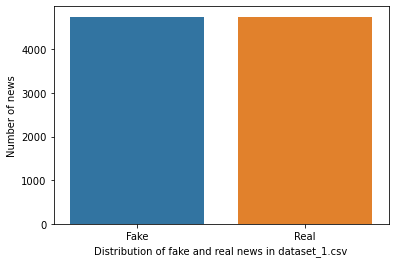

In [3]:
dataF = Preprocessing('dataset_1.csv')
dataF.data_distribution()

Below you can see the distribution of fake and real news for second dataset. It can be seen that the dataset is balanced.

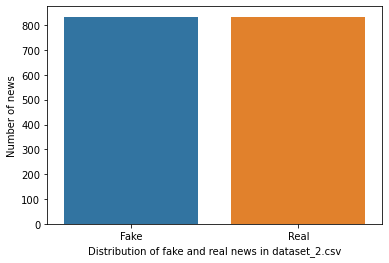

In [4]:
dataF = Preprocessing('dataset_2.csv')
dataF.data_distribution()

### 2.2. Comparison of the work of stemming and lemitization in Russian

In this paragraph, I give a clear example of why I chose lemitization and not stemming for the Russian language.

In [5]:
# Create two different objects for lemitization and stemming using test dataset
test_df_stem = Preprocessing('test_data.csv')
test_df_lem = Preprocessing('test_data.csv')

# pre-process the data and use lemitization or stemming
data_using_stem = test_df_stem.data_preprocess(lowercasing = True,
                                              space_del = True,
                                              urls_del = True,
                                              punctuation_del = True,
                                              stopwords_del = False,
                                              most_freq_words_del = [True, 0],
                                              stemming = True,
                                              lemmatization = False,
                                              tfidf_vect = False)

data_using_lem = test_df_lem.data_preprocess(lowercasing = True,
                                              space_del = True,
                                              urls_del = True,
                                              punctuation_del = True,
                                              stopwords_del = False,
                                              most_freq_words_del = [True, 0],
                                              stemming = False,
                                              lemmatization = True,
                                              tfidf_vect = False)


# translate the result into a common Pandas DataFrame for visual display
stem_words = data_using_stem['news_text'][0]
lem_words = data_using_lem['news_text'][0]
original_words = ['ей', 'нее', 'она', 'ею', 'ней']

dict_stem = {}
dict_lem = {}
dict_original = {}

for i in range(0, len(original_words)):
    dict_stem[i] = stem_words[i]
    dict_lem[i] = lem_words[i]
    dict_original[i] = original_words[i]
    

result_dict = {"original words:": dict_original,
               "stemmed words:": dict_stem,
               "lemmatized words:": dict_lem}

pd.DataFrame(result_dict)

,original words:,stemmed words:,lemmatized words:
0,ей,е,она
1,нее,не,она
2,она,он,она
3,ею,е,она
4,ней,не,она


## 3. Training and testing of ML algorithms
In this part of the project, all ML algorithms are trained on two datasets and then the required tests are carried out to evaluate them.

Preparing two sets of data

In [6]:
dataF_1 = Preprocessing('dataset_1.csv')

X_1, y_1 = dataF_1.data_preprocess(lowercasing = True,
                                  space_del = True,
                                  urls_del = True,
                                  punctuation_del = True,
                                  stopwords_del = True,
                                  most_freq_words_del = [True, 30],
                                  lemmatization = True,
                                  tfidf_vect = True)

dataF_2 = Preprocessing('dataset_2.csv')

X_2, y_2 = dataF_2.data_preprocess(lowercasing = True,
                                  space_del = True,
                                  urls_del = True,
                                  punctuation_del = True,
                                  stopwords_del = True,
                                  most_freq_words_del = [True, 30],
                                  lemmatization = True,
                                  tfidf_vect = True)

We divide the data into training and testing in the proportion of 80:20

In [7]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1,
                                                            y_1,
                                                            test_size=0.2,
                                                            random_state=1)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2,
                                                            y_2,
                                                            test_size=0.2,
                                                            random_state=2)



We train classical ML algorithms on the first data set and evaluate their performance on the first test data set

In [8]:
# create our ML algorithms
lr = LogisticRegression(random_state=0)
lsvc = LinearSVC(random_state=0)
knnc = KNeighborsClassifier()

# train algorithms
lr.fit(X_train_1,y_train_1)
lsvc.fit(X_train_1,y_train_1)
knnc.fit(X_train_1,y_train_1)

# Checking the algorithms on a test data set
lr_pred_df1 = lr.predict(X_test_1)
lsvc_pred_df1 = lsvc.predict(X_test_1)
knnc_pred_df1 = knnc.predict(X_test_1)


We train classical ML algorithms on the second data set and evaluate their performance on the second test data set

In [9]:
# create our ML algorithms
lr = LogisticRegression(random_state=0)
lsvc = LinearSVC(random_state=0)
knnc = KNeighborsClassifier()

# train algorithms
lr.fit(X_train_2,y_train_2)
lsvc.fit(X_train_2,y_train_2)
knnc.fit(X_train_2,y_train_2)

# Checking the algorithms on a test data set
lr_pred_df2 = lr.predict(X_test_2)
lsvc_pred_df2 = lsvc.predict(X_test_2)
knnc_pred_df2 = knnc.predict(X_test_2)

We train ensemble ML algorithms on the first data set and evaluate their performance on the first test data set

In [10]:
# create our ML algorithms
rfc_1 = RandomForestClassifier(random_state=0)
abc_1 = AdaBoostClassifier(random_state=0)

estimators_1 = [('rfc', RandomForestClassifier(random_state=12)),
              ('lsvc', LinearSVC(random_state=12)),
              ('knnc', KNeighborsClassifier())]

sc_1 = StackingClassifier(estimators=estimators_1,
                         final_estimator=LogisticRegression(random_state=12))

# train algorithms
rfc_1.fit(X_train_1,y_train_1)
abc_1.fit(X_train_1,y_train_1)
sc_1.fit(X_train_1,y_train_1)

# Checking the algorithms on a test data set
rfc_pred_df1 = rfc_1.predict(X_test_1)
abc_pred_df1 = abc_1.predict(X_test_1)
sc_pred_df1 = sc_1.predict(X_test_1)                     

We train ensemble ML algorithms on the second data set and evaluate their performance on the second test data set

In [11]:
# create our ML algorithms
rfc_2 = RandomForestClassifier(random_state=0)
abc_2 = AdaBoostClassifier(random_state=0)

estimators_2 = [('rfc', RandomForestClassifier(random_state=12)),
              ('lsvc', LinearSVC(random_state=12)),
              ('knnc', KNeighborsClassifier())]

sc_2 = StackingClassifier(estimators=estimators_2,
                          final_estimator=LogisticRegression(random_state=12))

# train algorithms
rfc_2.fit(X_train_2,y_train_2)
abc_2.fit(X_train_2,y_train_2)
sc_2.fit(X_train_2,y_train_2)

# Checking the algorithms on a test data set
rfc_pred_df2 = rfc_2.predict(X_test_2)
abc_pred_df2 = abc_2.predict(X_test_2)
sc_pred_df2 = sc_2.predict(X_test_2)

## 4. Evaluation of results

For data analysis, I decided to display all the results in several tables. Below is a function that builds a table.

In [12]:
# Function to create a table
def draw_table(values):
    # declare the required column and row names
    cols = ["Dataset 1", "Dataset 2", "Dataset similar to Dataset 2"]
    rows = ["Baseline algorithms:",
            "Logistic Regression (LR)",
            "Linear SVM (LSVM)",
            "KNN Classifier (KNN)",
            "Ensemble  learners:",
            "Random Forest (RF)",
            "Ada Boost",
            "Stacking (RF, LSVM, KNN, LR)",
            "Benchmark science works:",
            "Fake news detection for the Russian language [5] - RuBERT ",
            "Fake news detection for the Russian language [5] - LR ”bag-of-rst”"]
    
    # remove unnecessary elements of the chart
    fig, axes = plt.subplots()
    fig.patch.set_visible(False)
    axes.axis('off')
    axes.axis('tight')
    
    # create a table
    dataTable = plt.table(cellText=values,
                          colWidths=[0.1] * 3,
                          rowLabels=rows,
                          colLabels=cols,
                          loc='center',
                          cellLoc = 'center')
    
    # change text and table display options
    dataTable.auto_set_font_size(False)
    dataTable.set_fontsize(14)
    dataTable.scale(6, 2)

    plt.show()

### 4.1. F1-score table
Below is a table with all the results of the assessment using f1-score.

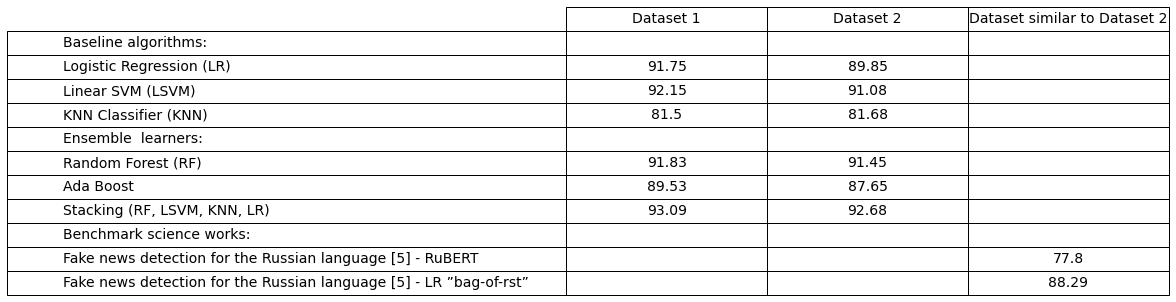

In [13]:
f1_score_values = [
    [" ", " ", " "],
    [round(f1_score(y_test_1,lr_pred_df1)*100, 2), round(f1_score(y_test_2,lr_pred_df2)*100, 2), " "],
    [round(f1_score(y_test_1,lsvc_pred_df1)*100, 2), round(f1_score(y_test_2,lsvc_pred_df2)*100, 2), " "],
    [round(f1_score(y_test_1,knnc_pred_df1)*100, 2), round(f1_score(y_test_2,knnc_pred_df2)*100, 2), " "],
    [" ", " ", " "],
    [round(f1_score(y_test_1,rfc_pred_df1)*100, 2), round(f1_score(y_test_2,rfc_pred_df2)*100, 2), " "],
    [round(f1_score(y_test_1,abc_pred_df1)*100, 2), round(f1_score(y_test_2,abc_pred_df2)*100, 2), " "],
    [round(f1_score(y_test_1,sc_pred_df1)*100, 2), round(f1_score(y_test_2,sc_pred_df2)*100, 2), " "],
    [" ", " ", " "],
    [" ", " ", 77.8],
    [" ", " ", 88.29]
]

draw_table(f1_score_values)

### 4.2. Accuracy score table
Below is a table with all the results of the assessment using accuracy score.

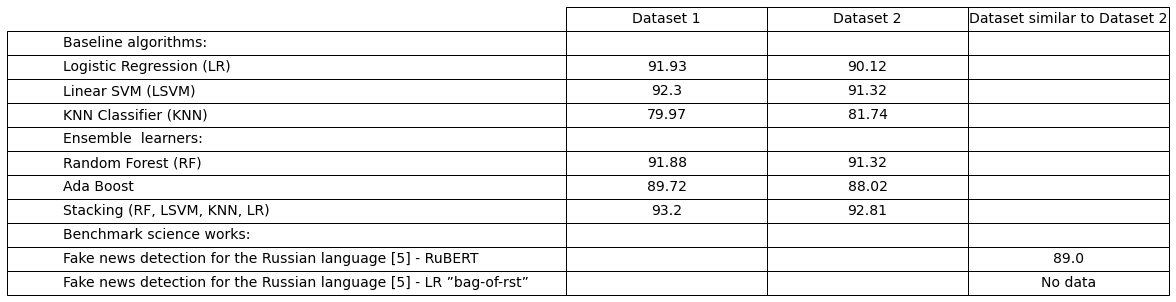

In [14]:
accuracy_values = [
    [" ", " ", " "],
    [round(accuracy_score(y_test_1,lr_pred_df1)*100, 2), round(accuracy_score(y_test_2,lr_pred_df2)*100, 2), " "],
    [round(accuracy_score(y_test_1,lsvc_pred_df1)*100, 2), round(accuracy_score(y_test_2,lsvc_pred_df2)*100, 2), " "],
    [round(accuracy_score(y_test_1,knnc_pred_df1)*100, 2), round(accuracy_score(y_test_2,knnc_pred_df2)*100, 2), " "],
    [" ", " ", " "],
    [round(accuracy_score(y_test_1,rfc_pred_df1)*100, 2), round(accuracy_score(y_test_2,rfc_pred_df2)*100, 2), " "],
    [round(accuracy_score(y_test_1,abc_pred_df1)*100, 2), round(accuracy_score(y_test_2,abc_pred_df2)*100, 2), " "],
    [round(accuracy_score(y_test_1,sc_pred_df1)*100, 2), round(accuracy_score(y_test_2,sc_pred_df2)*100, 2), " "],
    [" ", " ", " "],
    [" ", " ", 89.0],
    [" ", " ", "No data"]
]

draw_table(accuracy_values)

### 4.3. ROC-AUC score table
Below is a table with all the results of the assessment using ROC-AUC score.

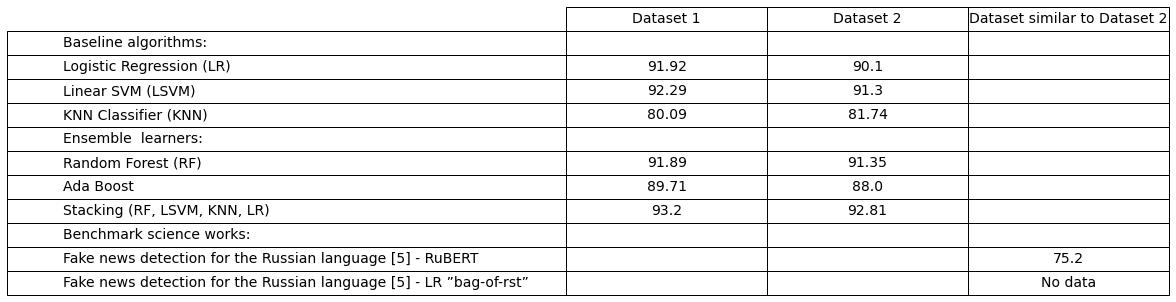

In [15]:
roc_auc_values = [
    [" ", " ", " "],
    [round(roc_auc_score(y_test_1,lr_pred_df1)*100, 2), round(roc_auc_score(y_test_2,lr_pred_df2)*100, 2), " "],
    [round(roc_auc_score(y_test_1,lsvc_pred_df1)*100, 2), round(roc_auc_score(y_test_2,lsvc_pred_df2)*100, 2), " "],
    [round(roc_auc_score(y_test_1,knnc_pred_df1)*100, 2), round(roc_auc_score(y_test_2,knnc_pred_df2)*100, 2), " "],
    [" ", " ", " "],
    [round(roc_auc_score(y_test_1,rfc_pred_df1)*100, 2), round(roc_auc_score(y_test_2,rfc_pred_df2)*100, 2), " "],
    [round(roc_auc_score(y_test_1,abc_pred_df1)*100, 2), round(roc_auc_score(y_test_2,abc_pred_df2)*100, 2), " "],
    [round(roc_auc_score(y_test_1,sc_pred_df1)*100, 2), round(roc_auc_score(y_test_2,sc_pred_df2)*100, 2), " "],
    [" ", " ", " "],
    [" ", " ", 75.2],
    [" ", " ", "No data"]
]

draw_table(roc_auc_values)